**This is the notebook for the practical part of lab 1.** 

Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import KeyedVectors
import gensim.downloader as api
from gensim.models import Word2Vec
import re
import copy

import data_loading_code as dlc

## Load data
small dataset

In [2]:
# get and pre-process data 
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)

data.columns = ['Sentence', 'Class']
data['index'] = data.index # add new column index
columns = ['index', 'Class', 'Sentence']
data = dlc.preprocess_pandas(data, columns) # pre-process

# split the data into training, validation, and test splits
# first get 50% for training
X_train, X_rest, y_train, y_rest = train_test_split(
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.5,
    random_state=0,
    shuffle=True
)

# split rest to get 50/20/30 split
X_val, X_test, y_val, y_test = train_test_split(
    X_rest,
    y_rest,
    test_size=0.6,  # 60% of 50% = 30% test
    random_state=0,
    shuffle=True
)

large dataset

In [3]:
data_large = pd.read_csv("amazon_cells_labelled_LARGE_25K.txt", delimiter='\t', header=None)
data_large.columns = ['Sentence', 'Class']
data_large['index'] = data_large.index
data_large = dlc.preprocess_pandas(data_large, columns)

X_train_l, X_rest_l, y_train_l, y_rest_l = train_test_split(
    data_large['Sentence'].values.astype('U'),
    data_large['Class'].values.astype('int32'),
    test_size=0.5,
    random_state=42,
    shuffle=True
)

X_val_l, X_test_l, y_val_l, y_test_l = train_test_split(
    X_rest_l, y_rest_l, test_size=0.6, random_state=42, shuffle=True
)

## Vectorise using tfidf

small dataset

In [4]:
# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')

X_train_vec = word_vectorizer.fit_transform(X_train).todense() # transform texts to sparse matrix and then to dense matrix for Pytorch
X_val_vec = word_vectorizer.transform(X_val).todense()
X_test_vec = word_vectorizer.transform(X_test).todense()

# convert to tensors
train_x_tensor = torch.from_numpy(np.array(X_train_vec)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor)

val_x_tensor = torch.from_numpy(np.array(X_val_vec)).type(torch.FloatTensor)
val_y_tensor = torch.from_numpy(np.array(y_val)).type(torch.FloatTensor)

test_x_tensor = torch.from_numpy(np.array(X_test_vec)).type(torch.FloatTensor)
test_y_tensor = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor)

# Build datasets and DataLoader
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
val_dataset = TensorDataset(val_x_tensor, val_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

large dataset

In [5]:
# vectorize data using TFIDF and transform for PyTorch for scalability
vectorizer_large = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')

X_train_l_vec = vectorizer_large.fit_transform(X_train_l).todense()
X_val_l_vec = vectorizer_large.transform(X_val_l).todense()
X_test_l_vec = vectorizer_large.transform(X_test_l).todense()

# convert to tensors
train_x_tensor_l = torch.from_numpy(np.array(X_train_l_vec)).type(torch.FloatTensor)
train_y_tensor_l = torch.from_numpy(np.array(y_train_l)).type(torch.FloatTensor)
val_x_tensor_l = torch.from_numpy(np.array(X_val_l_vec)).type(torch.FloatTensor)
val_y_tensor_l = torch.from_numpy(np.array(y_val_l)).type(torch.FloatTensor)
test_x_tensor_l = torch.from_numpy(np.array(X_test_l_vec)).type(torch.FloatTensor)
test_y_tensor_l = torch.from_numpy(np.array(y_test_l)).type(torch.FloatTensor)

# build datasets and DataLoader
train_loader_large = DataLoader(TensorDataset(train_x_tensor_l, train_y_tensor_l), batch_size=32, shuffle=True)
val_loader_large = DataLoader(TensorDataset(val_x_tensor_l, val_y_tensor_l), batch_size=32, shuffle=False)
test_loader_large = DataLoader(TensorDataset(test_x_tensor_l, test_y_tensor_l), batch_size=32, shuffle=False)

## Sentence embeddings using Word2Vec for vectorization

In [6]:
# # load pretrained word2vec model with dimension 100
# word2vec_model = api.load("glove-wiki-gigaword-100")
# embedding_dim = 100 

In [7]:
sentences = list(X_train) + list(X_val) + list(X_test)

# Tokenize sentences
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

In [ ]:
# Train Word2Vec 
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,       # dimension of vectors
    window=5,              
    min_count=1,           # min. appearance of a word in dataset
    workers=4,             
    sg=0                   # 1 = skip-gram, 0 = CBOW
)

In [9]:
# Function to convert sentences into embeddings
def sentence_to_vec(sentence, model, embedding_dim=100):
    words = sentence.split()
    vec = torch.zeros(embedding_dim)
    word_count = 0
    for word in words:
        if word in model.wv:
            vec += torch.tensor(model.wv[word])
            word_count += 1
    if word_count > 0:
        vec /= word_count
    return vec

# Convert all sentences to embeddings for the datasets
def create_dataset(X, y, word2vec_model, embedding_dim=100):
    x_tensor = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X])
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Binary labels as float32
    return x_tensor, y_tensor

small dataset

In [28]:
# # Convert all sentences to embeddings for the datasets
# train_x_tensor_w2v = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X_train])
# train_y_tensor_w2v = torch.tensor(y_train, dtype=torch.float32)  # Binary labels as float32

# val_x_tensor_w2v = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X_val])
# val_y_tensor_w2v = torch.tensor(y_val, dtype=torch.float32)

# test_x_tensor_w2v = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X_test])
# test_y_tensor_w2v = torch.tensor(y_test, dtype=torch.float32)

# Create Tensor datasets
train_x_tensor_w2v, train_y_tensor_w2v = create_dataset(X_train, y_train, word2vec_model)
val_x_tensor_w2v, val_y_tensor_w2v = create_dataset(X_val, y_val, word2vec_model)
test_x_tensor_w2v, test_y_tensor_w2v = create_dataset(X_test, y_test, word2vec_model)

# Build datasets and DataLoaders
train_loader_w2v = DataLoader(TensorDataset(train_x_tensor_w2v, train_y_tensor_w2v), batch_size=32, shuffle=True)
val_loader_w2v = DataLoader(TensorDataset(val_x_tensor_w2v, val_y_tensor_w2v), batch_size=32, shuffle=False)
test_loader_w2v = DataLoader(TensorDataset(test_x_tensor_w2v, test_y_tensor_w2v), batch_size=32, shuffle=False)

large dataset

In [29]:
# Create Tensor datasets
train_x_tensor_w2v_l, train_y_tensor_w2v_l = create_dataset(X_train_l, y_train_l, word2vec_model)
val_x_tensor_w2v_l, val_y_tensor_w2v_l = create_dataset(X_val_l, y_val_l, word2vec_model)
test_x_tensor_w2v_l, test_y_tensor_w2v_l = create_dataset(X_test_l, y_test_l, word2vec_model)

# Build datasets and DataLoaders
train_loader_w2v_l = DataLoader(TensorDataset(train_x_tensor_w2v_l, train_y_tensor_w2v_l), batch_size=32, shuffle=True)
val_loader_w2v_l = DataLoader(TensorDataset(val_x_tensor_w2v_l, val_y_tensor_w2v_l), batch_size=32, shuffle=False)
test_loader_w2v_l = DataLoader(TensorDataset(test_x_tensor_w2v_l, test_y_tensor_w2v_l), batch_size=32, shuffle=False)

---

# ANN Classifier

In [12]:
class ANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc3 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

In [13]:
class SimpleANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(SimpleANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 8)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc2 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [14]:
class ANNClassifierLarge(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifierLarge, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.drop2 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(16, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = self.drop2(self.relu3(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))  # Sigmoid for binary classification
        return x

In [15]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_loss_array = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            labels = labels.float().unsqueeze(1)  # [batch, 1] for BCELoss
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_train_loss += loss.item()

        train_acc = 100 * correct / total
        training_loss = running_train_loss / len(train_loader)
        train_loss_array.append(training_loss)

        val_loss, val_acc, _, _ = test_model(loader=val_loader, model=model, criterion=criterion)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model.name)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    print(f"Best validation accuracy: {best_accuracy}%")
    return model


def test_model(loader, model=None, criterion=None, input_size=None):
    if model is None:
        model = ANNClassifier(input_size)
        model.load_state_dict(torch.load('amazonclass.pth'))

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            all_labels.extend(labels.squeeze().tolist())
            all_preds.extend(predicted.squeeze().tolist())

    loss = running_loss / len(loader)
    accuracy = 100 * correct / total

    return loss, accuracy, np.array(all_labels), np.array(all_preds)

In [16]:
def plot_confusion_matrix(all_labels=None, all_predictions=None, class_labels=None):
    if all_labels is None or all_predictions is None:
        print("Error: all_labels or all_predictions needs to be passed")
        return

    if class_labels is None:
        class_labels = ["Negative (0)", "Positive (1)"]  # Default

    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)
    # print("Confusion Matrix:\n", cm)

    # Plot it with descriptive labels
    fig, ax = plt.subplots(figsize=(6, 6))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

---

# Training and Evaluation of ANNs

## Train simple ANN Classifier on small dataset

In [17]:
model_name ='amazonclasssimple'
input_size = train_x_tensor.shape[1]
model = SimpleANNClassifier(input_size, model_name)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=250)

Epoch 1/250, Train Loss: 0.7817, Val Loss: 0.6899, Train Acc: 51.60%, Val Acc: 53.00%
Epoch 2/250, Train Loss: 0.7471, Val Loss: 0.6866, Train Acc: 49.60%, Val Acc: 53.50%
Epoch 3/250, Train Loss: 0.7139, Val Loss: 0.6763, Train Acc: 53.80%, Val Acc: 54.00%
Epoch 4/250, Train Loss: 0.6524, Val Loss: 0.6656, Train Acc: 60.80%, Val Acc: 55.00%
Epoch 5/250, Train Loss: 0.6316, Val Loss: 0.6551, Train Acc: 58.60%, Val Acc: 58.00%
Epoch 6/250, Train Loss: 0.6413, Val Loss: 0.6487, Train Acc: 62.80%, Val Acc: 57.50%
Epoch 7/250, Train Loss: 0.6088, Val Loss: 0.6422, Train Acc: 66.00%, Val Acc: 59.00%
Epoch 8/250, Train Loss: 0.6189, Val Loss: 0.6361, Train Acc: 62.00%, Val Acc: 65.00%
Epoch 9/250, Train Loss: 0.5706, Val Loss: 0.6324, Train Acc: 66.80%, Val Acc: 64.50%
Epoch 10/250, Train Loss: 0.5165, Val Loss: 0.6254, Train Acc: 72.60%, Val Acc: 64.50%
Epoch 11/250, Train Loss: 0.5529, Val Loss: 0.6217, Train Acc: 69.80%, Val Acc: 67.00%
Epoch 12/250, Train Loss: 0.5202, Val Loss: 0.6146, 

Accuracy on testing dataset: 82.0%
F1-Score: 0.83


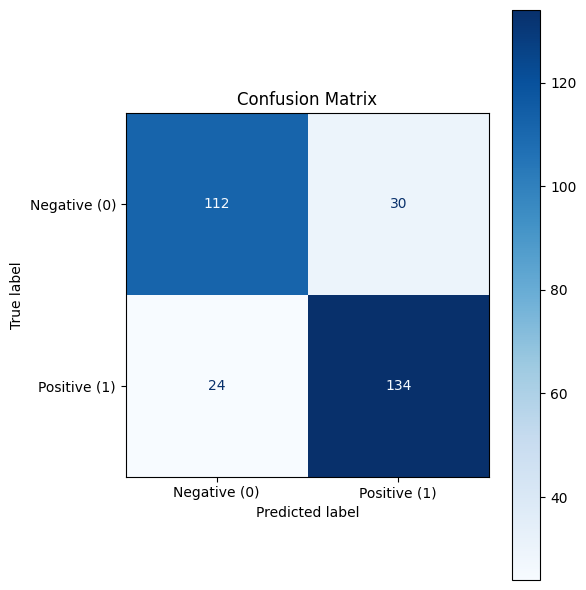

In [18]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train simple ANN Classifier on large dataset

In [19]:
model_name ='amazonclasssimplelarge'
input_size = train_x_tensor_l.shape[1]
model = SimpleANNClassifier(input_size, model_name)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_large, val_loader_large, num_epochs=25)

Epoch 1/25, Train Loss: 0.6074, Val Loss: 0.5053, Train Acc: 66.91%, Val Acc: 82.82%
Epoch 2/25, Train Loss: 0.5162, Val Loss: 0.4666, Train Acc: 79.74%, Val Acc: 85.26%
Epoch 3/25, Train Loss: 0.4745, Val Loss: 0.4381, Train Acc: 82.33%, Val Acc: 86.30%
Epoch 4/25, Train Loss: 0.4408, Val Loss: 0.4149, Train Acc: 84.58%, Val Acc: 86.54%
Epoch 5/25, Train Loss: 0.4173, Val Loss: 0.3948, Train Acc: 83.39%, Val Acc: 85.30%
Epoch 6/25, Train Loss: 0.3968, Val Loss: 0.3801, Train Acc: 83.66%, Val Acc: 86.58%
Epoch 7/25, Train Loss: 0.3771, Val Loss: 0.3744, Train Acc: 84.63%, Val Acc: 86.44%
Epoch 8/25, Train Loss: 0.3608, Val Loss: 0.3614, Train Acc: 85.18%, Val Acc: 86.88%
Epoch 9/25, Train Loss: 0.3496, Val Loss: 0.3501, Train Acc: 85.70%, Val Acc: 87.44%
Epoch 10/25, Train Loss: 0.3412, Val Loss: 0.3583, Train Acc: 86.17%, Val Acc: 85.88%
Epoch 11/25, Train Loss: 0.3298, Val Loss: 0.3579, Train Acc: 86.10%, Val Acc: 86.14%
Epoch 12/25, Train Loss: 0.3167, Val Loss: 0.3353, Train Acc: 8

Accuracy on testing dataset: 88.2%
F1-Score: 0.90


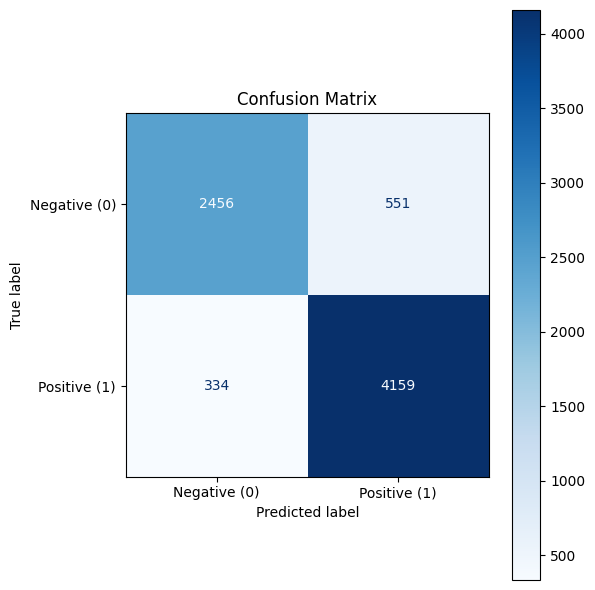

In [20]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_large, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train ANN Classifier on large dataset

In [21]:
model_name_l = 'amazonclasslarge'
input_size = train_x_tensor_l.shape[1]
model = ANNClassifier(input_size, model_name_l)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_large, val_loader_large, num_epochs=25)

Epoch 1/25, Train Loss: 0.6234, Val Loss: 0.4880, Train Acc: 55.63%, Val Acc: 82.72%
Epoch 2/25, Train Loss: 0.4768, Val Loss: 0.3843, Train Acc: 70.61%, Val Acc: 87.26%
Epoch 3/25, Train Loss: 0.3642, Val Loss: 0.3318, Train Acc: 89.70%, Val Acc: 87.36%
Epoch 4/25, Train Loss: 0.3026, Val Loss: 0.3269, Train Acc: 92.18%, Val Acc: 86.90%
Epoch 5/25, Train Loss: 0.2537, Val Loss: 0.3281, Train Acc: 93.75%, Val Acc: 86.28%
Epoch 6/25, Train Loss: 0.2212, Val Loss: 0.3582, Train Acc: 94.14%, Val Acc: 86.32%
Epoch 7/25, Train Loss: 0.2078, Val Loss: 0.3767, Train Acc: 94.62%, Val Acc: 86.06%
Epoch 8/25, Train Loss: 0.1980, Val Loss: 0.3861, Train Acc: 94.23%, Val Acc: 85.92%
Epoch 9/25, Train Loss: 0.1889, Val Loss: 0.3868, Train Acc: 94.52%, Val Acc: 86.32%
Epoch 10/25, Train Loss: 0.1826, Val Loss: 0.4094, Train Acc: 94.55%, Val Acc: 86.46%
Epoch 11/25, Train Loss: 0.1807, Val Loss: 0.4233, Train Acc: 94.16%, Val Acc: 86.26%
Epoch 12/25, Train Loss: 0.1757, Val Loss: 0.4382, Train Acc: 9

Accuracy on testing dataset: 87.85333333333334%
F1-Score: 0.90


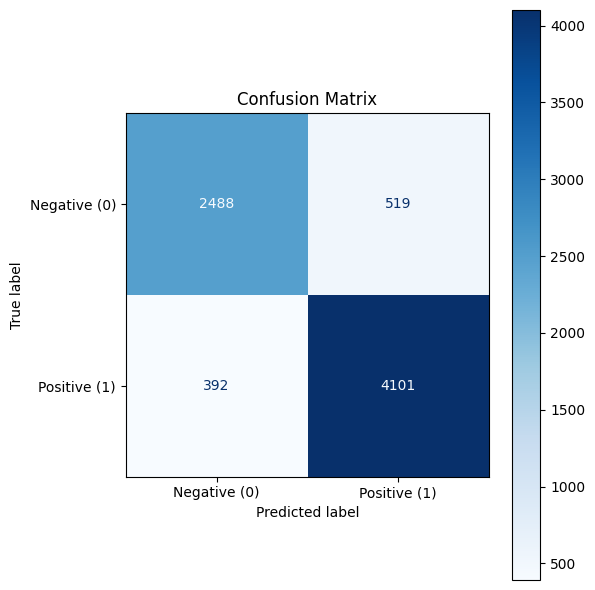

In [22]:
# Load best model
model = ANNClassifier(input_size, model_name_l)
model.load_state_dict(torch.load(model.name))

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_large, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

---

## Train ANN with word embeddings
small dataset and small model

In [30]:
model_name ='amazonclasssimplew2v'
input_size = train_x_tensor_w2v.shape[1]
model = SimpleANNClassifier(input_size, model_name)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, train_loader_w2v, val_loader_w2v, num_epochs=500)

Epoch 1/500, Train Loss: 0.7253, Val Loss: 0.7036, Train Acc: 50.20%, Val Acc: 47.00%
Epoch 2/500, Train Loss: 0.7393, Val Loss: 0.7085, Train Acc: 48.20%, Val Acc: 47.00%
Epoch 3/500, Train Loss: 0.7142, Val Loss: 0.6998, Train Acc: 47.60%, Val Acc: 47.00%
Epoch 4/500, Train Loss: 0.7135, Val Loss: 0.7064, Train Acc: 49.80%, Val Acc: 47.00%
Epoch 5/500, Train Loss: 0.7090, Val Loss: 0.7055, Train Acc: 50.20%, Val Acc: 47.00%
Epoch 6/500, Train Loss: 0.6968, Val Loss: 0.7194, Train Acc: 53.20%, Val Acc: 47.00%
Epoch 7/500, Train Loss: 0.6948, Val Loss: 0.7088, Train Acc: 54.80%, Val Acc: 46.50%
Epoch 8/500, Train Loss: 0.7081, Val Loss: 0.7044, Train Acc: 53.00%, Val Acc: 51.00%
Epoch 9/500, Train Loss: 0.7211, Val Loss: 0.7079, Train Acc: 51.40%, Val Acc: 47.00%
Epoch 10/500, Train Loss: 0.6956, Val Loss: 0.7031, Train Acc: 53.00%, Val Acc: 49.00%
Epoch 11/500, Train Loss: 0.7214, Val Loss: 0.7112, Train Acc: 51.40%, Val Acc: 48.00%
Epoch 12/500, Train Loss: 0.7077, Val Loss: 0.7130, 

Accuracy on testing dataset: 61.666666666666664%
F1-Score: 0.50


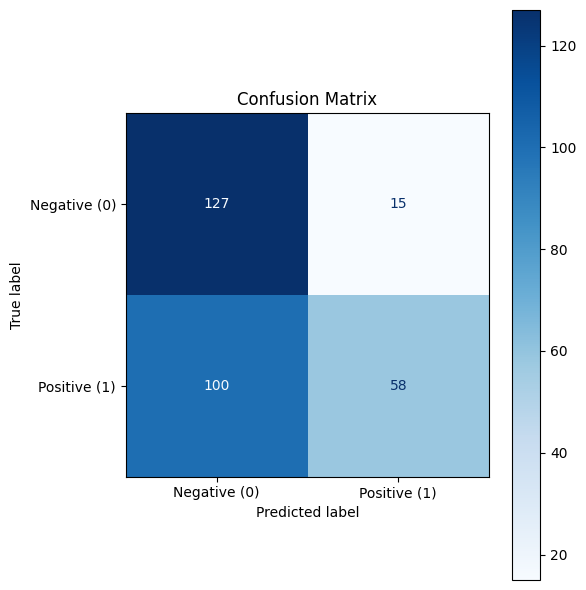

In [31]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_w2v, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

larger dataset and larger model

In [32]:
model_name ='amazonclasssimplew2vlarge'
input_size = train_x_tensor_w2v_l.shape[1]
model = ANNClassifierLarge(input_size, model_name)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, train_loader_w2v_l, val_loader_w2v_l, num_epochs=50)

Epoch 1/50, Train Loss: 0.6653, Val Loss: 0.7020, Train Acc: 60.09%, Val Acc: 42.16%
Epoch 2/50, Train Loss: 0.6198, Val Loss: 1.4270, Train Acc: 66.13%, Val Acc: 61.72%
Epoch 3/50, Train Loss: 0.6087, Val Loss: 0.9394, Train Acc: 66.59%, Val Acc: 42.28%
Epoch 4/50, Train Loss: 0.5962, Val Loss: 0.6326, Train Acc: 67.99%, Val Acc: 67.56%
Epoch 5/50, Train Loss: 0.5856, Val Loss: 1.0331, Train Acc: 69.34%, Val Acc: 40.14%
Epoch 6/50, Train Loss: 0.5885, Val Loss: 0.6264, Train Acc: 68.71%, Val Acc: 64.22%
Epoch 7/50, Train Loss: 0.5858, Val Loss: 0.6549, Train Acc: 69.30%, Val Acc: 65.14%
Epoch 8/50, Train Loss: 0.5888, Val Loss: 0.5969, Train Acc: 68.58%, Val Acc: 68.40%
Epoch 9/50, Train Loss: 0.5803, Val Loss: 0.6716, Train Acc: 69.32%, Val Acc: 65.96%
Epoch 10/50, Train Loss: 0.5803, Val Loss: 0.9077, Train Acc: 68.89%, Val Acc: 44.10%
Epoch 11/50, Train Loss: 0.5811, Val Loss: 0.7469, Train Acc: 68.91%, Val Acc: 48.52%
Epoch 12/50, Train Loss: 0.5748, Val Loss: 0.8116, Train Acc: 7

Accuracy on testing dataset: 72.69333333333333%
F1-Score: 0.77


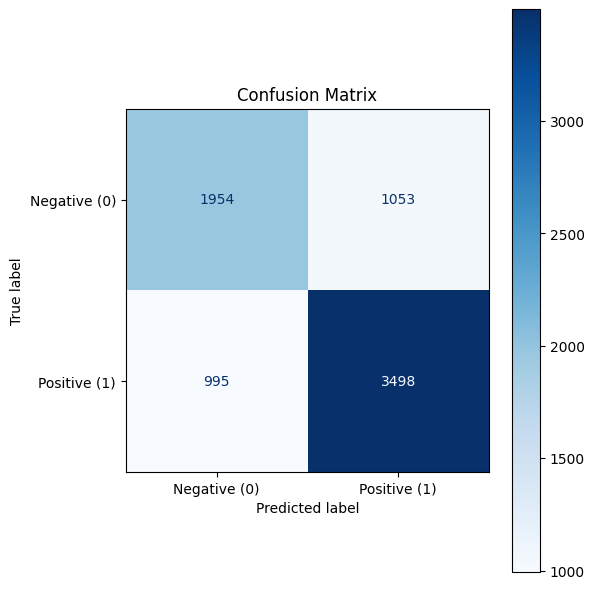

In [33]:
# Load best model
model = ANNClassifierLarge(input_size, model_name)
model.load_state_dict(torch.load(model.name))

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_w2v_l, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)